# Environment Setup

Mount Drive

Navigate to data/audio

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

%cd "/content/drive/My Drive/data/audio"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/data/audio


Check GPU connection

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Install additional packages (e.g. librosa)

In [3]:
!pip install librosa

    100% |████████████████████████████████| 1.6MB 17.1MB/s 
    100% |████████████████████████████████| 327kB 26.8MB/s 
    100% |████████████████████████████████| 3.2MB 10.3MB/s 
    100% |████████████████████████████████| 16.1MB 2.8MB/s 
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy


In [4]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import random
import glob
import re
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


# Data Exploration

Example of spectrograms of different meters

Clearly there is some difference in structure in melspectrograms

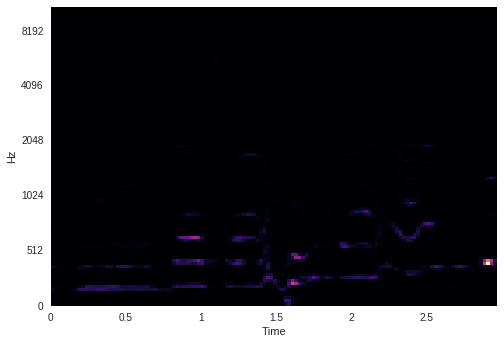

In [0]:
# Example of spectrogram
y, sr = librosa.load('01_10003_1-04_Shri_Visvanatham.wav',
                     offset = 25.0, duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(ps, y_axis='mel', x_axis='time');

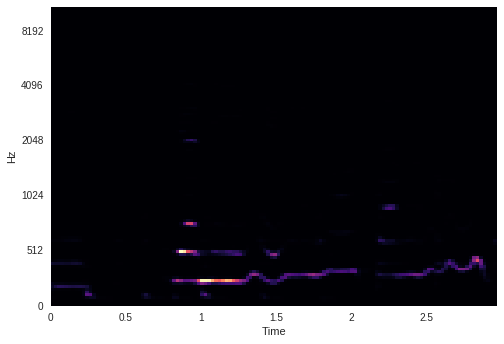

In [0]:
# Example of spectrogram
y, sr = librosa.load('01_11001_3_Sankari_Neeve.wav',
                     offset = 45.00, duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

# Data Preprocessing

Extract song names and corresponding meters

Encode song meters to integers for classifier

**model and preprocessing code largely based on:**
*   Code Emporium on YouTube: *Sound Play with Convolution Neural Networks*
*   Code Emporium's (Ajay Halthor) code on GitHub: *audio-classifier-convNet*
*   arXiv paper for model specification: https://arxiv.org/pdf/1608.04363.pdf (by *Justin Salamon and Juan Pablo Bello at MARL/CUSP at NYU*)


In [5]:
# Extract song names
songs = [re.search('.+?(?=\.wav)', x).group(0)
              for x in glob.iglob('*.wav')]
# Extract song meter
meter = []
for song in songs:
    with open('../annotations/meter/' + song + '.meter', 'r') as file:
        meter.append(file.readline())

# Encode song meter to integer
le = LabelEncoder()
meter_enc = le.fit_transform(meter)
meter[:5] , meter_enc[:5], songs[:5]
len(meter_enc), len(songs)


(118, 118)

Create dataset as list of tuples -- (song name, melspectrogram array, meter encoding)

Created random melspec snapshots of ~3s b/w 10s and 80s of each song

\# of random melspec snapshots (30) affects total sample size = # snapshots * # songs

Takes long time (and memory!) to build dataset --> bottle neck of script

Improvements:

*   Create generator to feed in batches of training & validation data in real-tim
*   Preprocess data in a multicore manner



In [25]:
D = [] # Dataset

for i, song in enumerate(songs):
    if (i%10 == 0):
      print(i) #comment out to hide verbose output
    for j in range(60):
        y, sr = librosa.load(song + '.wav', 
                             offset = np.random.randint(10, 80),
                             duration=2.97)  
        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        if ps.shape != (128, 128): continue
        D.append( (song, ps, meter_enc[i]) )
    

0
10
20
30
40
50
60
70
80
90
100
110


In [28]:
print("Number of samples: ", len(D))

Number of samples:  7080


Create train-test splits

Reshape features for CNN input

Create one-hot matrices for labels for CNN input

In [0]:
import copy
from sklearn.preprocessing import MinMaxScaler

dataset = copy.deepcopy(D)
random.shuffle(dataset)

train = dataset[:5000]
test = dataset[5000:]

_, X_train, y_train = zip(*train)
_, X_test, y_test = zip(*test)

scaler = MinMaxScaler()

# Reshape for CNN input
X_train = np.array([(scaler.fit_transform(x)).reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([(scaler.fit_transform(x)).reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 4))
y_test = np.array(keras.utils.to_categorical(y_test, 4))

Specity, compile, and evaluate model

Model based on *Deep Convolutional Neural Networks and Data Augmentation for Environmental Sound Classification*

> arXiv: https://arxiv.org/pdf/1608.04363.pdf

Improvements:

*   Modify model architecture, loss, and optimizer to improve model
*   Assess model performance on a variety of measure appropriate for multinomial classification problem
*   Compare model performance with different inputs: percussive only, harmonics only, both (current)




In [0]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(4))
model.add(Activation('softmax'))

In [31]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=50,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 5000 samples, validate on 2080 samples
Epoch 1/50
5000/5000 [==============================] - 4s 827us/step - loss: 0.1058 - acc: 0.9670 - val_loss: 0.2666 - val_acc: 0.9231
Epoch 2/50
5000/5000 [==============================] - 3s 628us/step - loss: 0.0879 - acc: 0.9702 - val_loss: 0.3013 - val_acc: 0.9216
Epoch 3/50
5000/5000 [==============================] - 3s 624us/step - loss: 0.0582 - acc: 0.9796 - val_loss: 0.2683 - val_acc: 0.9264
Epoch 4/50
5000/5000 [==============================] - 3s 622us/step - loss: 0.0448 - acc: 0.9868 - val_loss: 0.2857 - val_acc: 0.9274
Epoch 5/50
5000/5000 [==============================] - 3s 630us/step - loss: 0.0496 - acc: 0.9830 - val_loss: 0.2891 - val_acc: 0.9207
Epoch 6/50
5000/5000 [==============================] - 3s 628us/step - loss: 0.0856 - acc: 0.9708 - val_loss: 0.3125 - val_acc: 0.9183
Epoch 7/50
5000/5000 [==============================] - 3s 627us/step - loss: 0.0560 - acc: 0.9832 - val_loss: 0.3066 - val_acc: 0.9212


##Inception V3 Model

In [0]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
import glob
import re
import math
import keras
from keras import regularizers
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from random import shuffle
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
songs = (re.search('.+?(?=\.wav)', x).group(0)
              for x in glob.iglob('*.wav')) 

#build spectrograms for conv net
spectrograms = []
for song in songs:
  sample_rate, samples = wavfile.read(song+'.wav')
  frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
  spectrogram = spectrogram[:,10000:10500] #sample middle 2.5s of audio 
  with open('../annotations/meter/' + song + '.meter', 'r') as file:
      meter = file.readline()

  spectrograms.append([song, spectrogram, meter])


In [0]:
import random
def load_data(spec_data):
    split = 80
    
    random.shuffle(spec_data)
    
    x_train = np.array([x[1] for x in spec_data[:split]])
    y_train = np.array([x[2] for x in spec_data[:split]])
    
    x_test = np.array([x[1] for x in spec_data[split:]])
    y_test = np.array([x[2] for x in spec_data[split:]])
    
    return (x_train, y_train), (x_test, y_test)
 





In [0]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import cv2
from sklearn.preprocessing import LabelEncoder


(x_train, y_train), (x_test, y_test) = load_data(spectrograms)

#height and width of img
img_x, img_y = x_train.shape[1:]

#reshape x_train, x_test to 4D tensor - (samples, size1,size2,channels)
x_train = x_train.reshape((x_train.shape[0], img_x, img_y, 1))
x_test = x_test.reshape((x_test.shape[0], img_x, img_y, 1))

x_train = cv2.merge((x_train,x_train,x_train)).reshape((x_train.shape[0], img_x, img_y, 3))
x_test = cv2.merge((x_test, x_test, x_test)).reshape((x_test.shape[0], img_x, img_y, 3))


#process input for compatibility with InceptionV3 model
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)


le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 4)
y_test = keras.utils.to_categorical(y_test, 4)



print(np.sum(y_train, axis = 0)/len(y_train))
print(np.sum(y_test, axis = 0)/len(y_test))




[0.25   0.2125 0.25   0.2875]
[0.2631579  0.28947368 0.2631579  0.18421052]


In [0]:
from keras.layers import Input
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K


# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 4 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


for layer in model.layers:
   layer.trainable = True

# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss='categorical_crossentropy',  metrics=['accuracy'])
       

model.fit(x_train, y_train,
          batch_size=5,
          epochs=200,
          verbose=1,
          validation_data=(x_test, y_test))



Train on 80 samples, validate on 38 samples
Epoch 1/200
80/80 [==============================] - 34s 426ms/step - loss: 1.4603 - acc: 0.2625 - val_loss: 1.4682 - val_acc: 0.1842
Epoch 2/200
80/80 [==============================] - 4s 53ms/step - loss: 1.4050 - acc: 0.2625 - val_loss: 1.5100 - val_acc: 0.2368
Epoch 3/200
80/80 [==============================] - 4s 53ms/step - loss: 1.3517 - acc: 0.3500 - val_loss: 1.4930 - val_acc: 0.2368
Epoch 4/200
80/80 [==============================] - 4s 53ms/step - loss: 1.3640 - acc: 0.3125 - val_loss: 1.4737 - val_acc: 0.2368
Epoch 5/200
80/80 [==============================] - 4s 53ms/step - loss: 1.3251 - acc: 0.3750 - val_loss: 1.4954 - val_acc: 0.1316
Epoch 6/200
80/80 [==============================] - 4s 53ms/step - loss: 1.3484 - acc: 0.2625 - val_loss: 1.4711 - val_acc: 0.2105
Epoch 7/200
80/80 [==============================] - 4s 53ms/step - loss: 1.3009 - acc: 0.4000 - val_loss: 1.4967 - val_acc: 0.2368
Epoch 8/200
80/80 [===========